In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment4"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/MP4/" $datadir # TODO: Fill your Assignment 4 path
os.chdir(datadir)
!pwd

In [1]:
# NOTE: Loading data from Google Drive is VERY SLOW. Therefore, we download the data to a local storage
# specified by VOC_PATH.
# This means the data would have be re-downloaded everytime.
# Change this path if you are running this script locally
VOC_PATH="VOC_DATA"

!chmod u+x ./download_data.sh
!sed -i 's/\r//g' ./download_data.sh
!cat ./download_data.sh
!bash ./download_data.sh $VOC_PATH

#!/usr/bin/env bash

if [ "$#" -ne 1 ]; then
    echo "Usage: $0 <data_path>"
    exit 1
fi

DATA_DIR="$1"

mkdir -p "$DATA_DIR"

cd "$DATA_DIR" || { echo "Could not change directory to '$DATA_DIR'"; exit 1; }
# cd data

# download train
wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
tar -xf VOCtrainval_06-Nov-2007.tar
mv VOCdevkit VOCdevkit_2007
rm VOCtrainval_06-Nov-2007.tar

# download test and combine into same directory
wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
tar -xf VOCtest_06-Nov-2007.tar
mv VOCdevkit/VOC2007 VOCdevkit_2007/VOC2007test
rmdir VOCdevkit
rm VOCtest_06-Nov-2007.tar

# MIRROR Links (comment out above and uncomment out below if host.robots.ox.au.uk is down)

# wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
# tar -xf VOCtrainval_06-Nov-2007.tar
# mv VOCdevkit VOCdevkit_2007

# wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
# tar -xf VOCtest_06-Nov-2007.tar
# mv VOCdevki

In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader

from src.resnet_yolo import resnet50
import yolo_loss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## **Start from here if you modified yolo_loss.py and wish to retrain**

In [14]:
# No need to redownload every time
VOC_PATH="VOC_DATA"

In [15]:
# We recommend tuning only the batch size; the remaining hyperparameters should work well
# with the default values. However, you are free to experiment with them.

learning_rate = 0.001
num_epochs = 50
batch_size = 16

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [16]:
file_root_train = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007/JPEGImages/')
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [17]:
file_root_test = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007test/JPEGImages/')
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [18]:
data = train_dataset[0]

## Initializing the network

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [19]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


## Set up training tools

In [20]:
from importlib import reload
reload(yolo_loss) # update the import if the implementation has changed

criterion = yolo_loss.YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [21]:
best_test_loss = np.inf
learning_rate = learning_rate
f = open('output_file.txt', 'w')
os.makedirs('./checkpoints', exist_ok=True)
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    f.write('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    f.write('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
            f.write(outstring)

    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
        f.write(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        f.write('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')





Starting epoch 1 / 50
Learning Rate for this epoch: 0.001


KeyboardInterrupt: 

# View example predictions

predicting...


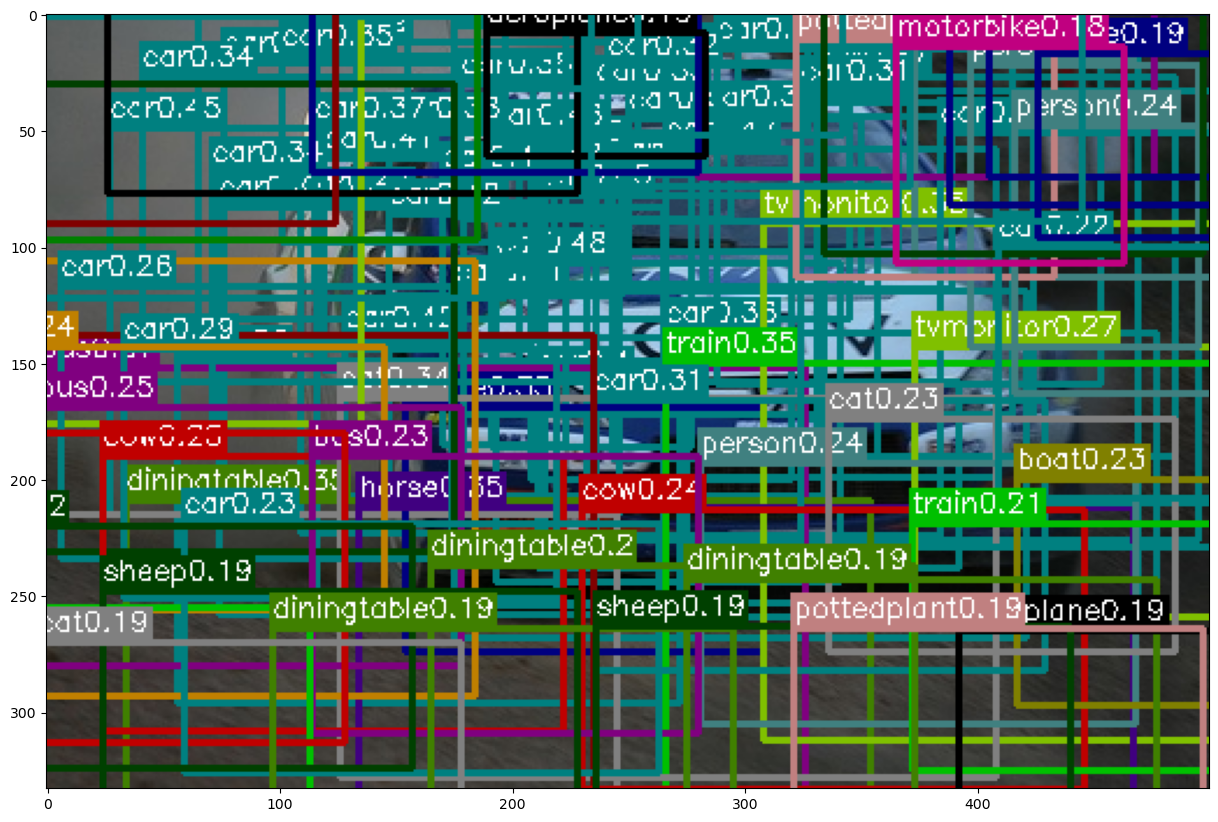

In [12]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [14]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [06:30<00:00, 12.67it/s]


---class aeroplane ap 0.5115136954652095---
---class bicycle ap 0.6370743413515696---
---class bird ap 0.49338062288699597---
---class boat ap 0.35155312137667966---
---class bottle ap 0.13635922621028362---
---class bus ap 0.5967742372977659---
---class car ap 0.6313208916256406---
---class cat ap 0.7631535009745193---
---class chair ap 0.26562764232192826---
---class cow ap 0.44364165106773---
---class diningtable ap 0.4420482861752154---
---class dog ap 0.673167276972793---
---class horse ap 0.6577231829145931---
---class motorbike ap 0.5650265865839711---
---class person ap 0.5545886599765201---
---class pottedplant ap 0.1715398000612016---
---class sheep ap 0.4334284780781417---
---class sofa ap 0.4904803952856016---
---class train ap 0.6810762218505086---
---class tvmonitor ap 0.46876031501520116---
---map 0.4984119066746035---


### Cell added to get intermediate mAP values for students

In [15]:
network_paths = ['./checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['./checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)


Loading saved network from ./checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [05:59<00:00, 13.79it/s]


---class aeroplane ap 0.001357022532913079---
---class bicycle ap 0.0004647056386196521---
---class bird ap 0.0006508020855184285---
---class boat ap 3.8554870906725747e-07---
---class bottle ap 2.2949049209416728e-07---
---class bus ap 3.8386119579160174e-05---
---class car ap 0.21046244004440617---
---class cat ap 0.007367088755603907---
---class chair ap 0.004775726601086861---
---class cow ap 0.0---
---class diningtable ap 0.0---
---class dog ap 0.002543322951904204---
---class horse ap 3.0788177339901475e-05---
---class motorbike ap 0.0---
---class person ap 0.297334493824679---
---class pottedplant ap 0.0006278221827874798---
---class sheep ap 7.834439149911122e-06---
---class sofa ap 0.0---
---class train ap 6.237641672436485e-06---
---class tvmonitor ap 0.00010669325265430567---
---map 0.02628869896435578---
Loading saved network from ./checkpoints/detector_epoch_10.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [06:21<00:00, 12.98it/s]


---class aeroplane ap 0.3088153070981461---
---class bicycle ap 0.2177174180482377---
---class bird ap 0.2626738270977835---
---class boat ap 0.00010751706773718623---
---class bottle ap 0.009255831392268736---
---class bus ap 0.1257751764396417---
---class car ap 0.39586754337376395---
---class cat ap 0.4396799277789122---
---class chair ap 0.10619436665025507---
---class cow ap 6.5130880504373545e-06---
---class diningtable ap 0.000832095267710097---
---class dog ap 0.38775425339126396---
---class horse ap 0.24139005174584982---
---class motorbike ap 5.252682766686501e-05---
---class person ap 0.41599065302646293---
---class pottedplant ap 0.05845527156390573---
---class sheep ap 0.005404648863734044---
---class sofa ap 4.742303241838495e-06---
---class train ap 0.0961419655274324---
---class tvmonitor ap 0.20586574479273675---
---map 0.16389926906724006---
Loading saved network from ./checkpoints/detector_epoch_20.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [06:18<00:00, 13.09it/s]


---class aeroplane ap 0.43013501832853485---
---class bicycle ap 0.5780721860659632---
---class bird ap 0.3767203082509878---
---class boat ap 0.2352501936080159---
---class bottle ap 0.1456585521635123---
---class bus ap 0.5005148791753662---
---class car ap 0.5316473301055176---
---class cat ap 0.6434570400144513---
---class chair ap 0.23842592833205503---
---class cow ap 0.355264579031937---
---class diningtable ap 0.37014226022333835---
---class dog ap 0.6118799243293416---
---class horse ap 0.5886291387877377---
---class motorbike ap 0.5004053889765785---
---class person ap 0.5037762179556278---
---class pottedplant ap 0.13825221395969786---
---class sheep ap 0.4283686395312377---
---class sofa ap 0.4179444488561701---
---class train ap 0.6076140005189529---
---class tvmonitor ap 0.4156425578186825---
---map 0.4308900403016853---
Loading saved network from ./checkpoints/detector_epoch_30.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [06:43<00:00, 12.28it/s]


---class aeroplane ap 0.4998879946443908---
---class bicycle ap 0.5573782703770362---
---class bird ap 0.4752033910891108---
---class boat ap 0.30689268248058954---
---class bottle ap 0.12268363582042818---
---class bus ap 0.5817439210080373---
---class car ap 0.6357610955820923---
---class cat ap 0.706404073638506---
---class chair ap 0.24124539360487085---
---class cow ap 0.3995265288979496---
---class diningtable ap 0.39381525339941026---
---class dog ap 0.6533039706929405---
---class horse ap 0.6496203700086431---
---class motorbike ap 0.5443667404865065---
---class person ap 0.5415445999252391---
---class pottedplant ap 0.16871528259507398---
---class sheep ap 0.4143886494098451---
---class sofa ap 0.4362369769648999---
---class train ap 0.650068673915223---
---class tvmonitor ap 0.4464190890286025---
---map 0.47126032967846976---
Loading saved network from ./checkpoints/detector_epoch_40.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [06:35<00:00, 12.50it/s]


---class aeroplane ap 0.5229524419839517---
---class bicycle ap 0.6362752561139564---
---class bird ap 0.48836272921615054---
---class boat ap 0.35318032015347933---
---class bottle ap 0.1318244403480595---
---class bus ap 0.603387993526709---
---class car ap 0.6234117585262055---
---class cat ap 0.7603455145849624---
---class chair ap 0.2609762468584442---
---class cow ap 0.43696505439780575---
---class diningtable ap 0.43272351515909474---
---class dog ap 0.6602551053033837---
---class horse ap 0.6666720772354139---
---class motorbike ap 0.5880188401695328---
---class person ap 0.5514832139077819---
---class pottedplant ap 0.16544415521664507---
---class sheep ap 0.42054614866672824---
---class sofa ap 0.4854992105395941---
---class train ap 0.6792530373193162---
---class tvmonitor ap 0.464941263561488---
---map 0.4966259161394352---
Loading saved network from ./checkpoints/detector.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [06:42<00:00, 12.29it/s]


---class aeroplane ap 0.5115136954652095---
---class bicycle ap 0.6370743413515696---
---class bird ap 0.49338062288699597---
---class boat ap 0.35155312137667966---
---class bottle ap 0.13635922621028362---
---class bus ap 0.5967742372977659---
---class car ap 0.6313208916256406---
---class cat ap 0.7631535009745193---
---class chair ap 0.26562764232192826---
---class cow ap 0.44364165106773---
---class diningtable ap 0.4420482861752154---
---class dog ap 0.673167276972793---
---class horse ap 0.6577231829145931---
---class motorbike ap 0.5650265865839711---
---class person ap 0.5545886599765201---
---class pottedplant ap 0.1715398000612016---
---class sheep ap 0.4334284780781417---
---class sofa ap 0.4904803952856016---
---class train ap 0.6810762218505086---
---class tvmonitor ap 0.46876031501520116---
---map 0.4984119066746035---


In [16]:
output_submission_csv('my_solution.csv', test_aps)